In [1]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


/home/lizhen09/miniconda2/envs/python27/lib/python2.7/site-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
sys.path.insert(0,os.getcwd()+"/../../src/main")

In [3]:
!echo $LOCAL

/local/5219345


In [4]:
!mkdir $LOCAL/sandbox

mkdir: cannot create directory ‘/local/5219345/sandbox’: File exists


In [5]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/local/5219345/sandbox'

In [6]:
os.environ['LANLEP_HOME']=HOME

In [7]:
import data

In [8]:
!ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/

In [9]:
!cp /home/lizhen09/lanlep2019/input/feat/*.pkl {HOME}/input/feat/

In [8]:
if 1:
    strategy = {'type':'byquake', "test_quakes":[[ 9,  4,  6] , [15,  1,  5], [10, 14,  3],  [7, 11,  2],  [8, 13, 12]]}
    types=['fwv']
    traintest = data.TrainTest('coverage', coverages=None, types=types, transform=None, valid_strategy=strategy)

In [9]:
testdf=traintest.get_test_data()
testdf.shape

(2624, 100)

In [10]:
datadf=pd.concat([traintest.traindf, traintest.ydf],axis=1)
print datadf.shape
datadf.head()

(419359, 101)


fwv_0     fwv_1     fwv_2     fwv_3     fwv_4  \
index                                                                  
quake_14_o38092704  0.059493  0.288745  0.175394 -0.306433  0.127363   
quake_05_o21076314  0.193220  0.223538  0.108353 -0.108521  0.048008   
quake_09_o34152517  0.195538  0.221066  0.115602 -0.111520  0.071273   
quake_07_o29907005  0.120579  0.257296  0.096898 -0.180808  0.078737   
quake_03_o11370843  0.219481  0.194752  0.059049 -0.080931  0.064311   

                       fwv_5     fwv_6     fwv_7     fwv_8     fwv_9  ...  \
index                                                                 ...   
quake_14_o38092704  0.078662  0.099293  0.320627  0.193841 -0.237509  ...   
quake_05_o21076314 -0.075768  0.018792  0.188903  0.167017 -0.079257  ...   
quake_09_o34152517 -0.085213 -0.029911  0.200946  0.154639 -0.073049  ...   
quake_07_o29907005 -0.026547  0.014643  0.191294  0.165722 -0.116214  ...   
quake_03_o11370843 -0.142953 -0.051948  0.098170  0.169367  0.026442  ...   

                      fwv_91    fwv_92    fwv_93    fwv_94    fwv_95  \
index                                                                  
quake_14_o38092704  0.119633  0.019761  0.043149  0.216871  0.032755   
quake_05_o21076314  0.173315  0.101008  0.032328  0.010907  0.033171   
quake_09_o34152517  0.195082  0.087095  0.034098 -0.026654  0.023064   
quake_07_o29907005  0.154124  0.055500  0.069783  0.097929  0.058242   
quake_03_o11370843  0.203573  0.129579  0.062429 -0.040362  0.015726   

                      fwv_96    fwv_97    fwv_98    fwv_99         y  
index                                                                 
quake_14_o38092704  0.095359 -0.141673 -0.095935  0.154893  4.818398  
quake_05_o21076314  0.027125 -0.087466 -0.007180  0.079947  2.541899  
quake_09_o34152517  0.001101 -0.098248  0.031839  0.082902  0.727197  
quake_07_o29907005  0.032560 -0.102489 -0.025202  0.069889  8.299899  
quake_03_o11370843  0.013697 -0.070627  0.042443 -0.026576  5.864797  

[5 rows x 101 columns]

In [11]:
datadf= datadf[~datadf.index.duplicated(keep='first')]
datadf.shape

(419248, 101)

In [12]:
qdf=pd.DataFrame(datadf.index.map(lambda u: u.split("_")[1]).astype(np.int8),index=datadf.index)
qdf.head()

index
index                    
quake_14_o38092704     14
quake_05_o21076314      5
quake_09_o34152517      9
quake_07_o29907005      7
quake_03_o11370843      3

In [13]:
qdf=qdf[~qdf['index'].isin({0,16})]
datadf=datadf.loc[qdf.index]
ydf=datadf['y']
datadf=datadf.drop('y',axis=1)
qdf.shape,datadf.shape,ydf.shape

((410717, 1), (410717, 100), (410717,))

In [15]:
ydf=ydf[ydf<10]
qdf=qdf.loc[ydf.index]
datadf=datadf.loc[qdf.index]
qdf.shape,datadf.shape,ydf.shape

((355899, 1), (355899, 100), (355899,))

In [16]:
qlen=qdf['index'].value_counts().to_dict()
str(qlen)

'{1: 25818, 2: 25719, 3: 22721, 4: 25742, 5: 20661, 6: 18112, 7: 25690, 8: 20285, 9: 24722, 10: 25933, 11: 25767, 12: 22648, 13: 21974, 14: 25838, 15: 24269}'

In [17]:
quakes=set(qdf['index'])
quakes

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [18]:
def make_distance(trainX,testX):
    a=np.expand_dims(trainX,1)
    print a.shape
    b=np.expand_dims(testX,0)
    print b.shape
    c=a-b
    print c.shape
    d=np.sqrt(np.sum(c*c, axis=2))
    print  d.shape
    return d
def make_distance2(trainX,testX):
    lst =[] 
    for i in range(len(testX)):
        x=testX[i:i+1]
        c=trainX-x
        d=np.sqrt(np.sum(c*c, axis=1))
        #print c.shape,x.shape,trainX.shape,d.shape        
        lst.append(d)
    return np.array(lst).T
def dmean2(a,n, y):
    aindex=np.argsort(a) 
    a=aindex[:n]
    y=y[a]
    a=(a-np.mean(a))/np.std(a)
    a=np.exp(-a)
    a=a/np.sum(a)
    return np.sum(a*y)
def dmean(v,ns,rawy):
    if not isinstance(ns, list):
        ns=[ns]
    for n in ns:
        assert n>0
    aindex=np.argsort(v) 
    lst=[]
    for n in ns:
        a=aindex[:n]
        y=rawy[a]
        a=(a-np.mean(a))/np.std(a)
        a=np.exp(-a)
        a=a/np.sum(a)
        r=np.sum(a*y)
        lst.append(r)
    return lst

In [19]:
results={}

In [20]:
%%time 
for qno in quakes:
    print qno
    testX=testdf.values
    print "test", testX.shape
    
    traindf=datadf[qdf['index']==qno]
    trainX=traindf.values
    trainy=ydf.loc[traindf.index].values
    print "train", trainX.shape,trainy.shape

    distances=make_distance2(trainX,testX)
    print distances.shape

    n=3000
    predy=np.apply_along_axis(lambda u: dmean2(u,n,trainy),axis=0,arr=distances)
    predy=np.array(predy)
    print predy.shape
    results[qno]=predy
    #break

1
test (2624, 100)
train (25818, 100) (25818,)
(25818, 2624)
(2624,)
2
test (2624, 100)
train (25719, 100) (25719,)
(25719, 2624)
(2624,)
3
test (2624, 100)
train (22721, 100) (22721,)
(22721, 2624)
(2624,)
4
test (2624, 100)
train (25742, 100) (25742,)
(25742, 2624)
(2624,)
5
test (2624, 100)
train (20661, 100) (20661,)
(20661, 2624)
(2624,)
6
test (2624, 100)
train (18112, 100) (18112,)
(18112, 2624)
(2624,)
7
test (2624, 100)
train (25690, 100) (25690,)
(25690, 2624)
(2624,)
8
test (2624, 100)
train (20285, 100) (20285,)
(20285, 2624)
(2624,)
9
test (2624, 100)
train (24722, 100) (24722,)
(24722, 2624)
(2624,)
10
test (2624, 100)
train (25933, 100) (25933,)
(25933, 2624)
(2624,)
11
test (2624, 100)
train (25767, 100) (25767,)
(25767, 2624)
(2624,)
12
test (2624, 100)
train (22648, 100) (22648,)
(22648, 2624)
(2624,)
13
test (2624, 100)
train (21974, 100) (21974,)
(21974, 2624)
(2624,)
14
test (2624, 100)
train (25838, 100) (25838,)
(25838, 2624)
(2624,)
15
test (2624, 100)
train (24

In [21]:
fig, axs = plt.subplots(figsize=(18,8), 
                        nrows=3, ncols=5,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

for ax,(k,v) in zip(axs.flatten(), results.items()):
    ax.hist(v,bins=50)
    ax.set_title('a=%d'%k)

In [22]:
for k,pred in results.items():
    a=pd.DataFrame(pred,index=testdf.index).reset_index()
    a.columns=["seg_id","time_to_failure"]
    a.to_csv("/home/lizhen09/lanlep2019//input/sub/test_covlt10_nnfwv_q{}.csv".format(k),index=None)

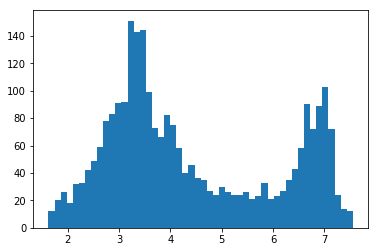

In [23]:
plt.hist(np.median(np.array(results.values()),0),bins=50);

In [24]:
pred=np.median(np.array(results.values()),0)
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
a.to_csv("/home/lizhen09/lanlep2019//input/sub/test_covltt10_nnfwv_qmed.csv".format(k),index=None)

In [25]:
%%time 
for qno in [111]:
    print qno
    testX=testdf.values
    print "test", testX.shape
    
    traindf=datadf
    trainX=traindf.values
    trainy=ydf.loc[traindf.index].values
    print "train", trainX.shape,trainy.shape

    distances=make_distance2(trainX,testX)
    print distances.shape

    n=3000
    predy=np.apply_along_axis(lambda u: dmean2(u,n,trainy),axis=0,arr=distances)
    predy=np.array(predy)
    print predy.shape
    #break

111
test (2624, 100)
train (355899, 100) (355899,)
(355899, 2624)
(2624,)
CPU times: user 9min 49s, sys: 3min 43s, total: 13min 32s
Wall time: 5min 35s


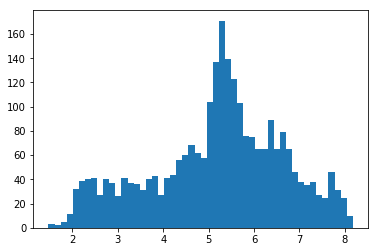

In [26]:
plt.hist(predy,bins=50);

In [27]:
a=pd.DataFrame(predy,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
a.to_csv("/home/lizhen09/lanlep2019//input/sub/test_covlt10_fwv_nnall.csv" ,index=None)

In [28]:
%%time 
for qno in [111]:
    print qno
    testX=testdf.values
    print "test", testX.shape
    
    traindf=datadf[~qdf['index'].isin({2,4,6})]
    trainX=traindf.values
    trainy=ydf.loc[traindf.index].values
    print "train", trainX.shape,trainy.shape

    distances=make_distance2(trainX,testX)
    print distances.shape

    n=3000
    predy=np.apply_along_axis(lambda u: dmean2(u,n,trainy),axis=0,arr=distances)
    predy=np.array(predy)
    print predy.shape
    #break
plt.hist(predy,bins=50); 
a=pd.DataFrame(predy,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
a.to_csv("/home/lizhen09/lanlep2019//input/sub/test_covlt10_fwv_nnall_rm-2-4-6.csv" ,index=None)

111
test (2624, 100)
train (286326, 100) (286326,)
(286326, 2624)
(2624,)
CPU times: user 8min 20s, sys: 2min 54s, total: 11min 14s
Wall time: 4min 35s
